In [81]:
import numpy as np 
import pandas as pd 
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix,recall_score,precision_score,f1_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

import math 

In [39]:
def process_data():
    df_test = pd.read_csv(r'test_data.csv', sep = ",")
    df_train = pd.read_csv(r'train_data.csv', sep = ",")

    test = df_test.drop(df_test.columns[0],axis=1)

    test_targets = test.iloc[:,[13]]
    test_inputs = test.loc[:,test.columns != 'target']

    train = df_train.drop(df_train.columns[0],axis=1)
    train_targets = train.iloc[:,[13]]
    train_inputs = train.loc[:,train.columns != 'target']
    
    np.savez('Spotify_data_train', inputs=train_inputs, targets=train_targets)
    np.savez('Spotify_data_test', inputs=test_inputs, targets=test_targets)

    npz = np.load('Spotify_data_train.npz')
    train_inputs,train_targets = npz['inputs'].astype(np.float),npz['targets'].astype(np.int)

    npz = np.load('Spotify_data_test.npz')
    test_inputs, test_targets = npz['inputs'].astype(np.float), npz['targets'].astype(np.int)

    test_inputs = preprocessing.scale(test_inputs)
    train_inputs = preprocessing.scale(train_inputs)
    
    return train_inputs,train_targets,test_inputs,test_targets

train_inputs,train_targets,test_inputs,test_targets = process_data()

total_samples = len(train_inputs)
split = math.ceil(total_samples/5)
k = 5

In [94]:
train_inputs[216*2]

array([-0.56499397,  0.65196689,  0.60878134, -1.35894407, -0.64960561,
       -0.75489302, -0.17480286, -0.22669493, -1.3141794 , -0.28171217,
        0.48892807,  0.14308134,  0.48264067,  0.67464915, -0.73249291,
        0.19554269,  0.25263439,  0.84969713])

# Evaluering av metoden med hyperparametre fra ModelCross

Forklarende tekst

In [ ]:
#Definisjon av parametre

hidden_layer_size = []
num_nodes 
num_layers
omtimizer


In [71]:
def build_model(n_nodes,n_layers):
    
    input_size = 17
    output_size = 2

    model = tf.keras.Sequential()
    model.add(layers.Dense(n_nodes, activation='relu',input_shape=(18,)))
    for i in range(n_layers-1):
        model.add(layers.Dense(n_nodes,kernel_regularizer=tf.keras.regularizers.l2(0.001), activation='relu'))
    model.add(layers.Dense(output_size, activation='softmax'))
    
    return model

def compile_model(model,chosen_optimizer):
    model.compile(optimizer=chosen_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

def fit_model(model,b_size,m_epochs):
    
    batch_size = b_size
    max_epochs = m_epochs
    
    history = model.fit(  train_inputs,train_targets,
                          batch_size=batch_size,
                          epochs=max_epochs,
                          validation_split = 0.2,
                          #validation_data=(v_inputs, v_targets),
                          #callbacks=[
                                #tf.keras.callbacks.TensorBoard(run_dir,histogram_freq=1,update_freq=1,embeddings_freq=1),
                                #tf.keras.callbacks.EarlyStopping(
                                    #monitor='val_accuracy', min_delta=0.001, patience=5, mode='max',
                                    #baseline=None),
                                #tf.keras.callbacks.EarlyStopping(
                                    #monitor='val_loss', min_delta=0.001, patience=7, verbose=0, mode='min',
                                    #baseline=0.6)
                                #],
                              verbose = 2) 
    return history


def plot_history(history):
    
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    epoch_count = range(1, len(training_loss) + 1)

    
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, validation_loss, 'b-')
    plt.plot(epoch_count,accuracy)
    plt.legend(['Training Loss', 'Validation Loss','Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show();
    
def evaluate_model(model):
    test_loss, test_accuracy = model.evaluate(test_inputs, test_targets)
    print('\nTest loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))
    
def predict(model,inputs):
    predictions = model.predict(inputs)
    predictions_arr = np.argmax(predictions,axis=1)
    return predictions,predictions_arr
  
    
def plot_value_array(i, predictions_array, true_label):
    true_label = test_targets[i]
    plt.grid(False)

    thisplot = plt.bar(range(2), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    
    plt.ylabel("{:2.0f}%".format(100*np.max(predictions_array),color=color))

    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label[0]].set_color('blue')
    
def plot_result(rows,cols,predictions):
    plt.figure(figsize=(2*2*cols, 2*rows))
    for i in range(rows*cols):
        plt.subplot(rows, 2*cols, 2*i+2)
        plot_value_array(i, predictions[i], test_targets)
    plt.tight_layout()
    plt.show()
    
def get_wrong_guess_data(predictions):
    wrong_guess = []
    for i in range(100):
        index = np.argmax(predictions[i])
        if(index!=test_targets[i]):
            arr = np.concatenate((test_inputs[i],test_targets[i])) 
            wrong_guess.append(arr)
            #wrong_guess.append(test_targets[i])
    return wrong_guess

In [91]:
def create_model(n_nodes,n_layers,optimizer,b_size,m_epochs):
    model = build_model(n_nodes,n_layers)
    compile_model(model,optimizer)
    history = fit_model(model,b_size,m_epochs)
    evaluate_model(model)
    predictions,predictions_arr = predict(model,test_inputs)
    plot_result(2,2,predictions)
    wrong_guesses = get_wrong_guess_data(predictions)
    print(' \nConfusion Matrix: \n',confusion_matrix(test_targets, predictions_arr))
    print('\nF1 Score:',f1_score(test_targets,predictions_arr))
    print('\nRecall Score:',recall_score(test_targets,predictions_arr))
    print('\nPrecision Score:',precision_score(test_targets,predictions_arr))

Epoch 1/10
98/98 - 1s - loss: 0.7011 - accuracy: 0.5713 - val_loss: 0.6855 - val_accuracy: 0.6159
Epoch 2/10
98/98 - 0s - loss: 0.6646 - accuracy: 0.6503 - val_loss: 0.6385 - val_accuracy: 0.6697
Epoch 3/10
98/98 - 0s - loss: 0.6126 - accuracy: 0.6901 - val_loss: 0.5967 - val_accuracy: 0.7009
Epoch 4/10
98/98 - 0s - loss: 0.5806 - accuracy: 0.7141 - val_loss: 0.5778 - val_accuracy: 0.7185
Epoch 5/10
98/98 - 0s - loss: 0.5649 - accuracy: 0.7242 - val_loss: 0.5669 - val_accuracy: 0.7263
Epoch 6/10
98/98 - 0s - loss: 0.5551 - accuracy: 0.7308 - val_loss: 0.5585 - val_accuracy: 0.7304
Epoch 7/10
98/98 - 0s - loss: 0.5480 - accuracy: 0.7347 - val_loss: 0.5516 - val_accuracy: 0.7320
Epoch 8/10
98/98 - 0s - loss: 0.5422 - accuracy: 0.7377 - val_loss: 0.5459 - val_accuracy: 0.7345
Epoch 9/10
98/98 - 0s - loss: 0.5376 - accuracy: 0.7397 - val_loss: 0.5403 - val_accuracy: 0.7398
Epoch 10/10
98/98 - 0s - loss: 0.5332 - accuracy: 0.7409 - val_loss: 0.5353 - val_accuracy: 0.7431
96/96 [============

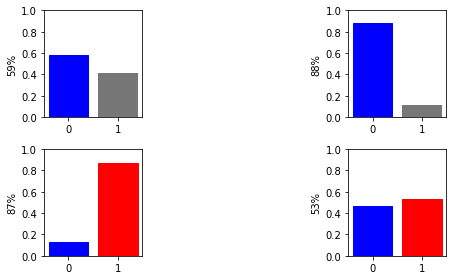

 
Confusion Matrix: 
 [[1126  396]
 [ 409 1115]]

F1 Score: 0.7347611202635913

Recall Score: 0.7316272965879265

Precision Score: 0.7379219060225016


In [92]:
create_model(5,5,'adam',100,10)

[[1108  414]
 [ 322 1202]]
0.7656050955414012
0.7887139107611548
0.7438118811881188
